In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time

from joblib import dump
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
plt.style.use('ggplot')

# 5-linear-models

Dane pochodzą z:
* https://www.kaggle.com/austinreese/craigslist-carstrucks-data
* https://github.com/AustinReese/UsedVehicleSearch

In [3]:
X_train = pd.read_csv('../data/processed/train_features.csv')
y_train = pd.read_csv('../data/processed/train_target.csv')

In [4]:
X_test = pd.read_csv('../data/processed/test_features.csv')
y_test = pd.read_csv('../data/processed/test_target.csv')

In [5]:
X_train = X_train.select_dtypes('number')
X_test = X_test.select_dtypes('number')

In [6]:
cols = X_train.columns.tolist()

In [7]:
assert list(X_train.columns) == list(X_test.columns)

In [8]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

In [9]:
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [10]:
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

## Linear model without regularization

In [11]:
lr = LinearRegression()

In [12]:
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
dump(lr, '../models/linear_regression.joblib')

['../models/linear_regression.joblib']

In [14]:
y_pred = lr.predict(X_test)

In [15]:
mean_squared_error(
    target_scaler.inverse_transform(y_test),
    target_scaler.inverse_transform(y_pred),
    squared=False
)

6155.513744627131

## Linear models with regularization

In [16]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

### Lasso

In [17]:
lasso = Lasso(random_state=42, max_iter=10_000)

param_grid = {
    'alpha': [10 ** i for i in range(-4, 4)]
}

In [18]:
t1 = time.time()
gscv = GridSearchCV(lasso, n_jobs=-1, cv=cv, param_grid=param_grid, verbose=1)
gscv.fit(X_train, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
102.49479246139526


In [19]:
lasso = gscv.best_estimator_
lasso

Lasso(alpha=0.0001, max_iter=10000, random_state=42)

In [20]:
dump(lasso, '../models/lasso_regression.joblib')

['../models/lasso_regression.joblib']

In [21]:
y_pred = lasso.predict(X_test)

In [22]:
mean_squared_error(
    target_scaler.inverse_transform(y_test),
    target_scaler.inverse_transform(y_pred),
    squared=False
)

6155.642398936258

In [23]:
lasso_coeffs = pd.DataFrame(
    data=zip(cols, lasso.coef_.tolist()), 
    columns=['Features', 'Coefficient']
)
lasso_coeffs.sort_values('Coefficient', ascending=False, inplace=True)

In [24]:
lasso_coeffs = lasso_coeffs[lasso_coeffs['Coefficient'].abs() >= 0.04]

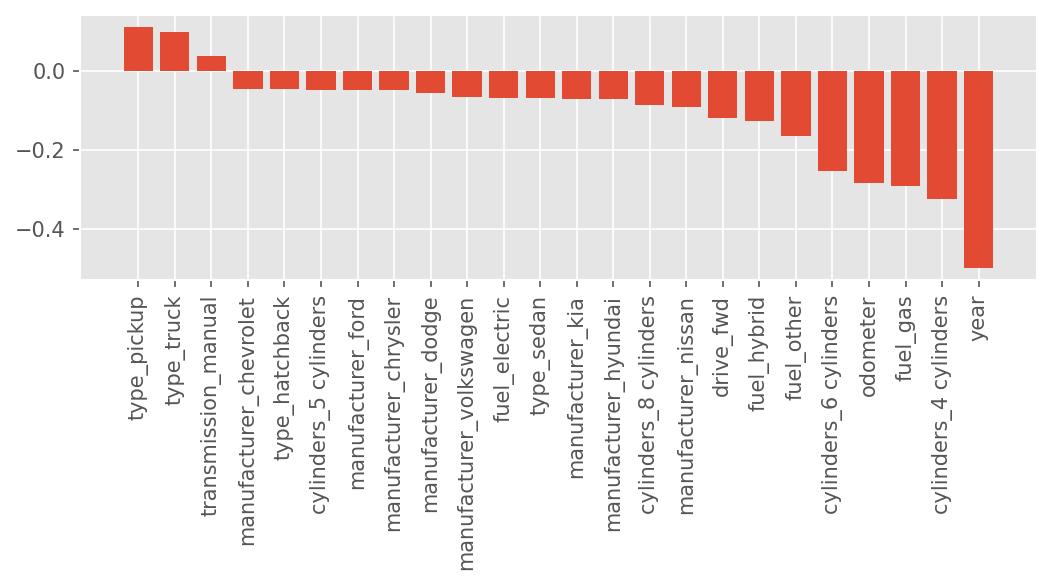

In [25]:
plt.figure(figsize=(4 * (16/9),4), dpi=150)
plt.bar(lasso_coeffs['Features'], lasso_coeffs['Coefficient'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'../reports/figures/lasso_coeffs.png')
plt.show()

## ElasticNet

In [26]:
elastic = ElasticNet(random_state=42, max_iter=10_000)

param_grid = {
    'alpha': [10 ** i for i in range(-4, 4)],
    'l1_ratio': [i/10 for i in range(1, 10)]
}

In [27]:
t1 = time.time()
gscv = GridSearchCV(elastic, n_jobs=-1, cv=cv, param_grid=param_grid, verbose=1)
gscv.fit(X_train, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
909.9855790138245


In [28]:
elastic = gscv.best_estimator_
elastic

ElasticNet(alpha=0.0001, l1_ratio=0.1, max_iter=10000, random_state=42)

In [29]:
dump(elastic, '../models/elastic_net_regression.joblib')

['../models/elastic_net_regression.joblib']

In [30]:
y_pred = elastic.predict(X_test)

In [31]:
mean_squared_error(
    target_scaler.inverse_transform(y_test),
    target_scaler.inverse_transform(y_pred),
    squared=False
)

6155.526841798947

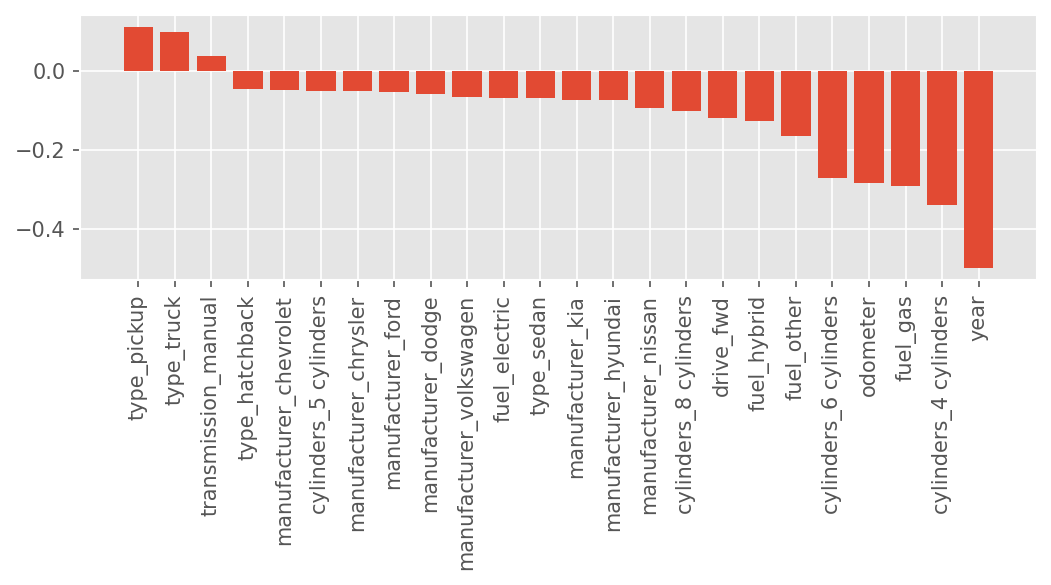

In [32]:
elastic_coeffs = pd.DataFrame(
    data=zip(cols, elastic.coef_.tolist()), 
    columns=['Features', 'Coefficient']
)
elastic_coeffs.sort_values('Coefficient', ascending=False, inplace=True)

elastic_coeffs = elastic_coeffs[elastic_coeffs['Coefficient'].abs() >= 0.04]

plt.figure(figsize=(4 * (16/9),4), dpi=150)
plt.bar(elastic_coeffs['Features'], elastic_coeffs['Coefficient'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'../reports/figures/elastic_coeffs.png')
plt.show()

## Ridge 

In [33]:
ridge = Ridge(random_state=42, max_iter=10_000)

param_grid = {
    'alpha': [10 ** i for i in range(-4, 4)]
}

In [34]:
t1 = time.time()
gscv = GridSearchCV(ridge, n_jobs=-1, cv=cv, param_grid=param_grid, verbose=1)
gscv.fit(X_train, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
5.851668834686279


In [35]:
ridge = gscv.best_estimator_
ridge

Ridge(alpha=1, max_iter=10000, random_state=42)

In [36]:
dump(ridge, '../models/ridge_regression.joblib')

['../models/ridge_regression.joblib']

In [37]:
y_pred = ridge.predict(X_test)

In [38]:
mean_squared_error(
    target_scaler.inverse_transform(y_test),
    target_scaler.inverse_transform(y_pred),
    squared=False
)

6155.5140128851435

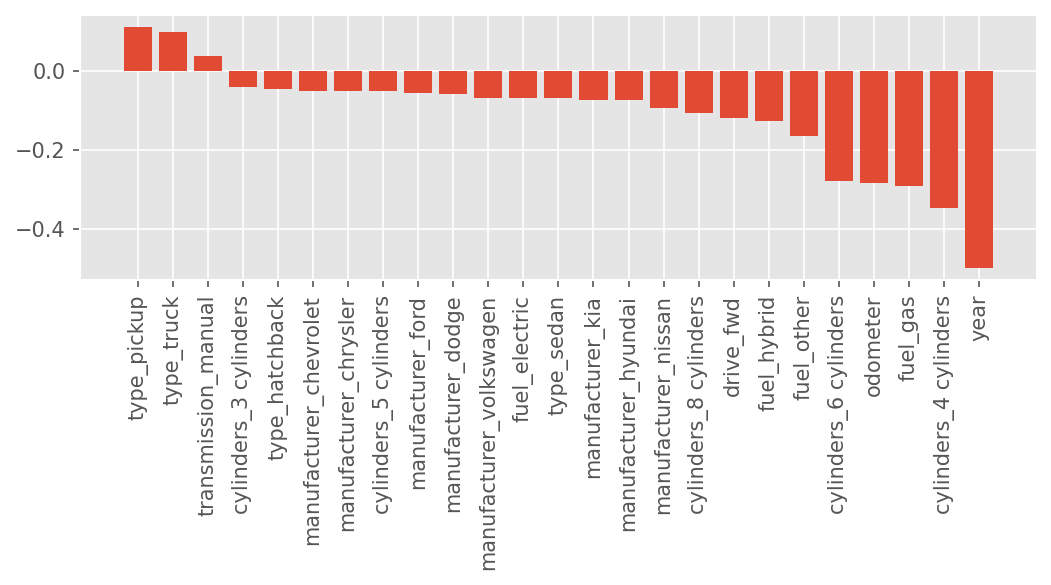

In [39]:
ridge_coeffs = pd.DataFrame(
    data=zip(cols, ridge.coef_.tolist()[0]), 
    columns=['Features', 'Coefficient']
)
ridge_coeffs.sort_values('Coefficient', ascending=False, inplace=True)

ridge_coeffs = ridge_coeffs[ridge_coeffs['Coefficient'].abs() >= 0.04]

plt.figure(figsize=(4 * (16/9),4), dpi=150)
plt.bar(ridge_coeffs['Features'], ridge_coeffs['Coefficient'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'../reports/figures/ridge_coeffs.png')
plt.show()